## Two models combined to do the classification of the sleep stages

This notebook is used to developp two models that will work together to do the classification. The first model will do the classification between wake and sleep. The second model will do the classification between the NREM and REM stages. Both models ar balanced random forest classifier.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
import os
from sklearn.preprocessing import StandardScaler, Normalizer 
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

import sys
sys.path.append('../Library')

import breedManip as breedManip
import dataProcessing as dataProcessing
import breeds as breeds
import splitData as splitData

import importlib
importlib.reload(splitData)


2023-07-27 10:29:17.971357: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-27 10:29:18.052567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-27 10:29:19.241094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<module 'splitData' from '/mnt/remote/workspaces/magali.egger/TBproject/Travail_Bachelor/ClassificationSimple/../Library/splitData.py'>

#### Preparation of the data for the two models
We use the data simplified from the third day and we remove the 40 mice used for the test set.

In [2]:
with open('/home/magali.egger/shared-projects/mice_UNIL/Data/df_simplify_day3.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
mice_test = ['BL601', 'BL602', 'BL606', 'BL609', '1D203', '2D203', '1D204', '1D206', '00505', '04501', '04502', '04504', '04505', '04506', '04508', '04801', '04802', '04803', '04804', '04805', '04806', '05001', '05002', '05003', '05004', '05005', '05006', '07901', '07902', '08405', '08502', '08503', '08901', '08902', '09001', '09003', '09004', '09005', '09006', '09007', '10101', '10102']
df = df[~df['mouse'].isin(mice_test)]
len(df['mouse'].unique())

212

In [4]:
len(df['breed'].unique())

36

In [5]:
df_train, df_test = splitData.split_data_breeds(df, 30)
len(df_train['mouse'].unique())

176

In [6]:
df_train = df_train.drop(columns=['mouse'])
df_train = df_train.drop(columns=['breed'])
df_test = df_test.drop(columns=['mouse'])
df_test = df_test.drop(columns=['breed'])

In [7]:
# df for the model wake/sleep needs labels 'n' and 'r' to be changed in 's'
df_train_ws= df_train.copy()
df_train_ws['rawState'] = df_train_ws['rawState'].replace(['n', 'r'], 's')
df_test_ws= df_test.copy()
df_test_ws['rawState'] = df_test_ws['rawState'].replace(['n', 'r'], 's')

In [8]:
x_train_ws, y_train_ws_raw = splitData.split_labels(df_train_ws)
y_train_ws, le_ws = splitData.encode_labels(y_train_ws_raw, cat_matrix=True)

scaler_ws = StandardScaler().fit(x_train_ws)
x_train_ws = scaler_ws.transform(x_train_ws)

In [9]:
# df for the model rem/nrem needs to remove the 'w' label
df_train_sleep = df_train.copy()
df_train_sleep = df_train_sleep[df_train_sleep['rawState'] != 'w']
df_test_sleep = df_test.copy()
df_test_sleep = df_test_sleep[df_test_sleep['rawState'] != 'w']

In [10]:
x_train_sleep, y_train_sleep_raw = splitData.split_labels(df_train_sleep)
y_train_sleep, le_sleep = splitData.encode_labels(y_train_sleep_raw, cat_matrix=True)

scaler_sleep = StandardScaler().fit(x_train_sleep)
x_train_sleep = scaler_sleep.transform(x_train_sleep)

In [11]:
x_test_ws, y_test_ws_raw = splitData.split_labels(df_test_ws)

y_test_ws = le_ws.transform(y_test_ws_raw)
y_test_ws = tf.keras.utils.to_categorical(y_test_ws)

x_test_ws = scaler_ws.transform(x_test_ws)


In [12]:
x_test_sleep, y_test_sleep_raw = splitData.split_labels(df_test_sleep)

y_test_sleep = le_sleep.transform(y_test_sleep_raw)
y_test_sleep = tf.keras.utils.to_categorical(y_test_sleep)

x_test_sleep = scaler_sleep.transform(x_test_sleep)

#### Training and testing of the first model : wake vs sleep

In [13]:
rfc_ws = RandomForestClassifier(random_state=23, n_jobs=-1, class_weight='balanced')
rfc_ws.fit(x_train_ws, y_train_ws)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)

In [14]:
y_pred_ws = rfc_ws.predict(x_test_ws)

[[284867  11958]
 [ 14108 392759]]
              precision    recall  f1-score   support

           s       0.95      0.96      0.96    296825
           w       0.97      0.97      0.97    406867

    accuracy                           0.96    703692
   macro avg       0.96      0.96      0.96    703692
weighted avg       0.96      0.96      0.96    703692



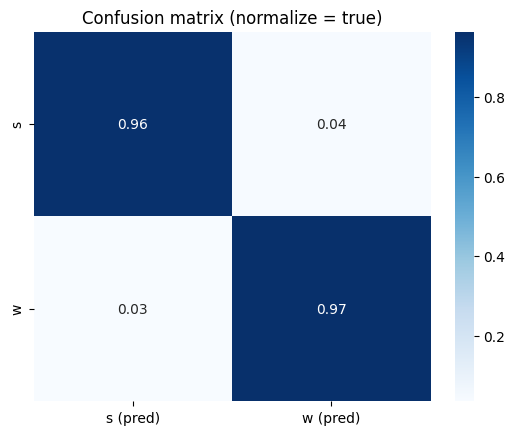

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
pred = np.argmax(y_pred_ws, axis=1)
test = np.argmax(y_test_ws, axis=1)

# plot the confusion matrix between predictions of the model and real values

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=le_ws.classes_, columns=le_ws.classes_ + ' (pred)')

print(classification_report(test, pred, target_names=le_ws.classes_, zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()

#### Training and testing of the second model : NREM vs REM

In [16]:
rfc_sleep = RandomForestClassifier(random_state=23, n_jobs=-1, class_weight='balanced')
rfc_sleep.fit(x_train_sleep, y_train_sleep)

/home/magali.egger/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/home/magali.egger/miniconda3/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/magali.egger/miniconda3/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/magali.egger/miniconda3/lib/python3.10/site

BalancedRandomForestClassifier(class_weight='balanced', n_jobs=-1,
                               random_state=23)

In [17]:
y_pred_sleep = rfc_sleep.predict(x_test_sleep)

[[258901      0]
 [ 37924      0]]


              precision    recall  f1-score   support

           n       0.87      1.00      0.93    258901
           r       0.00      0.00      0.00     37924

    accuracy                           0.87    296825
   macro avg       0.44      0.50      0.47    296825
weighted avg       0.76      0.87      0.81    296825



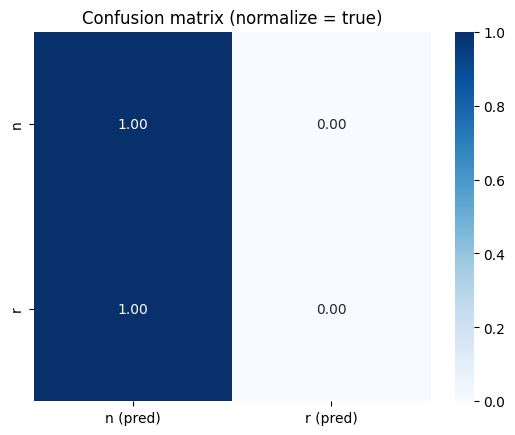

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
pred = np.argmax(y_pred_sleep, axis=1)
test = np.argmax(y_test_sleep, axis=1)

# plot the confusion matrix between predictions of the model and real values

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=le_sleep.classes_, columns=le_sleep.classes_ + ' (pred)')

print(classification_report(test, pred, target_names=le_sleep.classes_, zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()

#### Evaluation of the two models combined
The two models are used together to do the classification of the sleep stages. We use the data frame labelized : df_simplified_label.For each row  

Preparation of the label and features

In [19]:
with open('/home/magali.egger/shared-projects/mice_UNIL/Data/df_simplify_labels.pkl', 'rb') as f:
    df_simplify_labels = pickle.load(f)

In [20]:
# remove wierd labels
wierd_labels = ['a','8', 's', 'j', '1', '2', '3']
df_simplify_labels = df_simplify_labels[~df_simplify_labels['label'].isin(wierd_labels)]

In [21]:
df_simplify_labels = df_simplify_labels.drop(columns=['mouse'])
df_simplify_labels = df_simplify_labels.drop(columns=['breed'])

In [22]:
x_test, y_test_raw = splitData.split_labels_annotated(df_simplify_labels)
x_test_ws = scaler_ws.transform(x_test)
x_test_sleep = scaler_sleep.transform(x_test)

In [23]:
def convert(states):
    res = []
    for state in states:
        if state == 'n' or state == '5' or state=='2':
            res.append(0)
        elif state == 'r' or state=='6' or state=='3':
            res.append(1)
        elif state == 'w' or state=='4' or state=='1' or state=='9':
            res.append(2)
    return res

In [24]:
y_test = convert(y_test_raw)

Now that we have x_test and y_test ready, we can compute the prediction of the first model, if the prediction is sleep, we compute the prediction of the second model.

In [25]:
y_pred_ws = rfc_ws.predict(x_test_ws)
y_pred_sleep = rfc_sleep.predict(x_test_sleep)

In [26]:
pred_ws = np.argmax(y_pred_ws, axis=1)
pred_sleep = np.argmax(y_pred_sleep, axis=1)

In [27]:
result = []

for i in range(len(pred_ws)):
    if pred_ws[i] == 0:
        if pred_sleep[i] == 0:
            result.append(0)
        else:
            result.append(1)
    else:
        result.append(2)

[[1201590       0  140959]
 [ 137948       0   36199]
 [  60146       0 1472377]]
              precision    recall  f1-score   support

           n       0.86      0.90      0.88   1342549
           r       0.00      0.00      0.00    174147
           w       0.89      0.96      0.93   1532523

    accuracy                           0.88   3049219
   macro avg       0.58      0.62      0.60   3049219
weighted avg       0.83      0.88      0.85   3049219



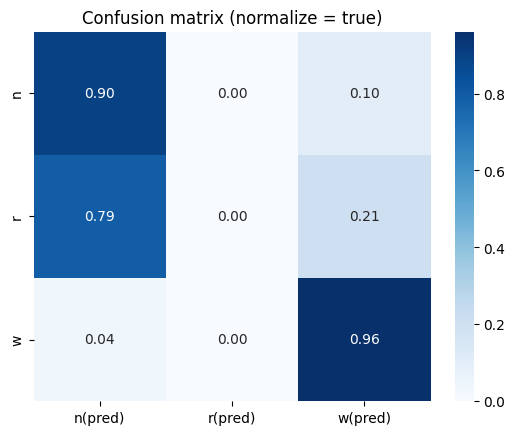

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
pred = result
test = y_test

# plot the confusion matrix between predictions of the model and real values

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=['n', 'r', 'w'], columns=['n(pred)', 'r(pred)', 'w(pred)'])

print(classification_report(test, pred, target_names=['n', 'r', 'w'], zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()

Redo the same thing but this time separate the results day by day.

In [29]:
def convert(states):
    res = []
    for state in states:
        if state == 'n' or state == '5' or state=='2':
            res.append(0)
        elif state == 'r' or state=='6' or state=='3':
            res.append(1)
        elif state == 'w' or state=='4' or state=='1' or state=='9':
            res.append(2)
    return res

[[295747      0  56771]
 [ 30457      0  13989]
 [ 14266      0 351403]]
              precision    recall  f1-score   support

           n       0.87      0.84      0.85    352518
           r       0.00      0.00      0.00     44446
           w       0.83      0.96      0.89    365669

    accuracy                           0.85    762633
   macro avg       0.57      0.60      0.58    762633
weighted avg       0.80      0.85      0.82    762633



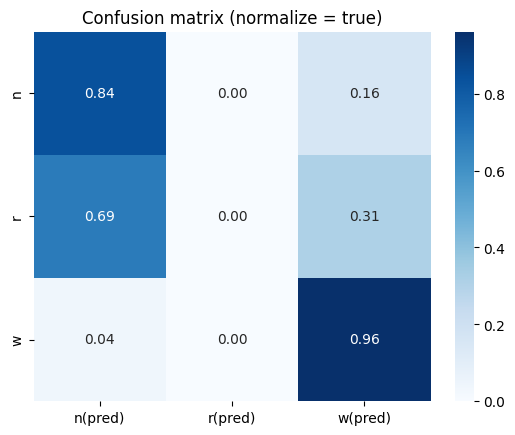

In [30]:
with open('/home/magali.egger/shared-projects/mice_UNIL/Data/df_simplify_labels.pkl', 'rb') as f:
    df_simplify_labels = pickle.load(f)

df_simplify_labels = df_simplify_labels[df_simplify_labels['day'] == 0]

wierd_labels = ['a','8', 's', 'j', '1', '2', '3']
df_simplify_labels = df_simplify_labels[~df_simplify_labels['label'].isin(wierd_labels)]
df_simplify_labels = df_simplify_labels.drop(columns=['mouse'])
df_simplify_labels = df_simplify_labels.drop(columns=['breed'])

x_test, y_test_raw = splitData.split_labels_annotated(df_simplify_labels)
x_test_ws = scaler_ws.transform(x_test)
x_test_sleep = scaler_sleep.transform(x_test)
y_test = convert(y_test_raw)

y_pred_ws = rfc_ws.predict(x_test_ws)
y_pred_sleep = rfc_sleep.predict(x_test_sleep)

pred_ws = np.argmax(y_pred_ws, axis=1)
pred_sleep = np.argmax(y_pred_sleep, axis=1)

result = []
for i in range(len(pred_ws)):
    if pred_ws[i] == 0:
        if pred_sleep[i] == 0:
            result.append(0)
        else:
            result.append(1)
    else:
        result.append(2)

from sklearn.metrics import classification_report, confusion_matrix
pred = result
test = y_test

# plot the confusion matrix between predictions of the model and real values

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=['n', 'r', 'w'], columns=['n(pred)', 'r(pred)', 'w(pred)'])

print(classification_report(test, pred, target_names=['n', 'r', 'w'], zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()

[[297514      0  55986]
 [ 31602      0  14174]
 [ 12515      0 360944]]
              precision    recall  f1-score   support

           n       0.87      0.84      0.86    353500
           r       0.00      0.00      0.00     45776
           w       0.84      0.97      0.90    373459

    accuracy                           0.85    772735
   macro avg       0.57      0.60      0.58    772735
weighted avg       0.80      0.85      0.83    772735



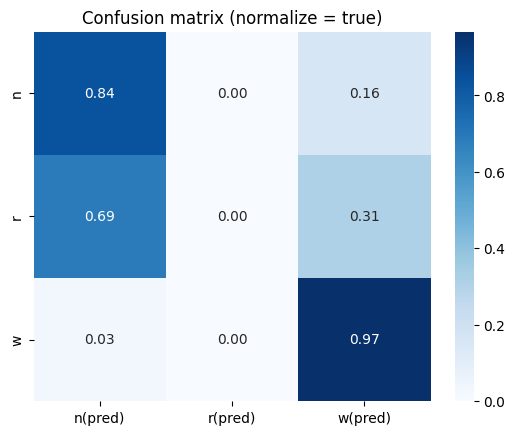

In [31]:
with open('/home/magali.egger/shared-projects/mice_UNIL/Data/df_simplify_labels.pkl', 'rb') as f:
    df_simplify_labels = pickle.load(f)
    
df_simplify_labels = df_simplify_labels[df_simplify_labels['day'] == 1]

wierd_labels = ['a','8', 's', 'j', '1', '2', '3']
df_simplify_labels = df_simplify_labels[~df_simplify_labels['label'].isin(wierd_labels)]
df_simplify_labels = df_simplify_labels.drop(columns=['mouse'])
df_simplify_labels = df_simplify_labels.drop(columns=['breed'])

x_test, y_test_raw = splitData.split_labels_annotated(df_simplify_labels)
x_test_ws = scaler_ws.transform(x_test)
x_test_sleep = scaler_sleep.transform(x_test)
y_test = convert(y_test_raw)

y_pred_ws = rfc_ws.predict(x_test_ws)
y_pred_sleep = rfc_sleep.predict(x_test_sleep)

pred_ws = np.argmax(y_pred_ws, axis=1)
pred_sleep = np.argmax(y_pred_sleep, axis=1)

result = []
for i in range(len(pred_ws)):
    if pred_ws[i] == 0:
        if pred_sleep[i] == 0:
            result.append(0)
        else:
            result.append(1)
    else:
        result.append(2)

from sklearn.metrics import classification_report, confusion_matrix
pred = result
test = y_test

# plot the confusion matrix between predictions of the model and real values

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=['n', 'r', 'w'], columns=['n(pred)', 'r(pred)', 'w(pred)'])

print(classification_report(test, pred, target_names=['n', 'r', 'w'], zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()

[[266408      0  12158]
 [ 35710      0   3611]
 [ 14382      0 412363]]
              precision    recall  f1-score   support

           n       0.84      0.96      0.90    278566
           r       0.00      0.00      0.00     39321
           w       0.96      0.97      0.96    426745

    accuracy                           0.91    744632
   macro avg       0.60      0.64      0.62    744632
weighted avg       0.87      0.91      0.89    744632



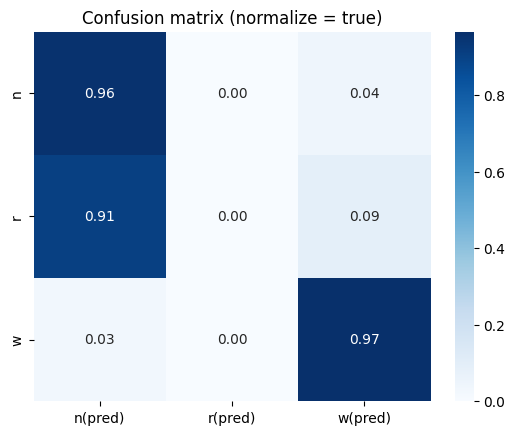

In [32]:
with open('/home/magali.egger/shared-projects/mice_UNIL/Data/df_simplify_labels.pkl', 'rb') as f:
    df_simplify_labels = pickle.load(f)

df_simplify_labels = df_simplify_labels[df_simplify_labels['day'] == 2]

wierd_labels = ['a','8', 's', 'j', '1', '2', '3']
df_simplify_labels = df_simplify_labels[~df_simplify_labels['label'].isin(wierd_labels)]
df_simplify_labels = df_simplify_labels.drop(columns=['mouse'])
df_simplify_labels = df_simplify_labels.drop(columns=['breed'])

x_test, y_test_raw = splitData.split_labels_annotated(df_simplify_labels)
x_test_ws = scaler_ws.transform(x_test)
x_test_sleep = scaler_sleep.transform(x_test)
y_test = convert(y_test_raw)

y_pred_ws = rfc_ws.predict(x_test_ws)
y_pred_sleep = rfc_sleep.predict(x_test_sleep)

pred_ws = np.argmax(y_pred_ws, axis=1)
pred_sleep = np.argmax(y_pred_sleep, axis=1)

result = []
for i in range(len(pred_ws)):
    if pred_ws[i] == 0:
        if pred_sleep[i] == 0:
            result.append(0)
        else:
            result.append(1)
    else:
        result.append(2)

from sklearn.metrics import classification_report, confusion_matrix
pred = result
test = y_test

# plot the confusion matrix between predictions of the model and real values

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=['n', 'r', 'w'], columns=['n(pred)', 'r(pred)', 'w(pred)'])

print(classification_report(test, pred, target_names=['n', 'r', 'w'], zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()

[[341921      0  16044]
 [ 40179      0   4425]
 [ 18983      0 347667]]
              precision    recall  f1-score   support

           n       0.85      0.96      0.90    357965
           r       0.00      0.00      0.00     44604
           w       0.94      0.95      0.95    366650

    accuracy                           0.90    769219
   macro avg       0.60      0.63      0.62    769219
weighted avg       0.85      0.90      0.87    769219



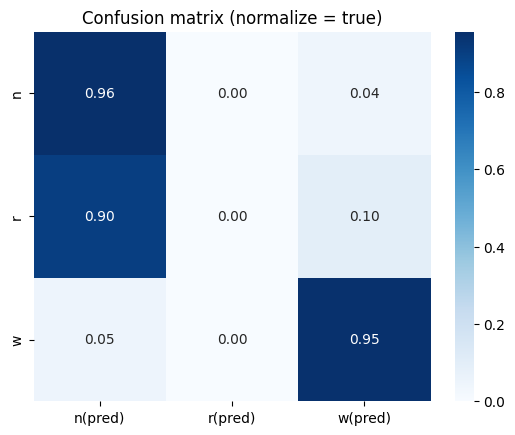

In [33]:
with open('/home/magali.egger/shared-projects/mice_UNIL/Data/df_simplify_labels.pkl', 'rb') as f:
    df_simplify_labels = pickle.load(f)

df_simplify_labels = df_simplify_labels[df_simplify_labels['day'] == 3]

wierd_labels = ['a','8', 's', 'j', '1', '2', '3']
df_simplify_labels = df_simplify_labels[~df_simplify_labels['label'].isin(wierd_labels)]
df_simplify_labels = df_simplify_labels.drop(columns=['mouse'])
df_simplify_labels = df_simplify_labels.drop(columns=['breed'])

x_test, y_test_raw = splitData.split_labels_annotated(df_simplify_labels)
x_test_ws = scaler_ws.transform(x_test)
x_test_sleep = scaler_sleep.transform(x_test)
y_test = convert(y_test_raw)

y_pred_ws = rfc_ws.predict(x_test_ws)
y_pred_sleep = rfc_sleep.predict(x_test_sleep)

pred_ws = np.argmax(y_pred_ws, axis=1)
pred_sleep = np.argmax(y_pred_sleep, axis=1)

result = []
for i in range(len(pred_ws)):
    if pred_ws[i] == 0:
        if pred_sleep[i] == 0:
            result.append(0)
        else:
            result.append(1)
    else:
        result.append(2)

from sklearn.metrics import classification_report, confusion_matrix
pred = result
test = y_test

# plot the confusion matrix between predictions of the model and real values

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=['n', 'r', 'w'], columns=['n(pred)', 'r(pred)', 'w(pred)'])

print(classification_report(test, pred, target_names=['n', 'r', 'w'], zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()